# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [19]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [8]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'

In [9]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x,limit=1e3, **kwargs):
    
    condition = np.isfinite(x) & (x < limit)
    sns.distplot(x[condition], **kwargs)

### Perform some basic filtering

In [10]:
adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [11]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [12]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


In [13]:
sc.pl.tsne(adata, color='cell_type')

In [14]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [15]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 3593


### Select immune genes using GO annotations

In [13]:
go_annotations = pd.read_csv(data_path + '../../GO_annotations-9606-inferred-allev.tsv', sep='\t')
go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
go_annotations = go_annotations\
    .query('go_domain == "biological_process"')\
    .explode('gene')[['go_name', 'gene']]

In [14]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

In [15]:
immune_genes = list(set(adata.var.index) & set(immune_genes))

In [16]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(immune_genes, f)

### Observed $\mu$-$CV^{2}$ Relationship

In [20]:
adata_sampled = adata[adata.obs.cell == 'CD4 T cells'].copy()

In [94]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [102]:
estimator.estimate_beta_sq(tolerance=3, compute_moments=False)

In [103]:
estimator.noise_level

0.12156906985686006

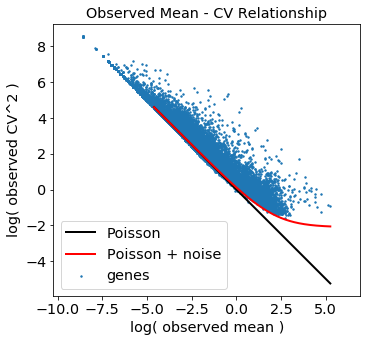

In [104]:
estimator.plot_cv_mean_curve()
#plt.savefig(data_path + 'figures/observed_cv_vs_mean.png', bbox_inches='tight')

### Change in STAT1 variability of expression predicts change in variability of expression of other genes

https://www.frontiersin.org/articles/10.3389/fimmu.2018.01135/full#B2

Genes that are canonically downstream of STAT1.

STAT1 and STAT2 are canonical signaling elements of the Type I interferon. These genes should definitely be correlated with immune genes upon stimulation.

In [85]:
with open(data_path + '../20200316/stim_effect_1d.pkl', 'rb') as f:
    stim_1d_dict = pkl.load(f)

In [92]:
list(zip(
    tfs,
    stim_1d_dict[('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim')]['de_fdr'][tf_gene_idxs]
))

[('JUN', 4.243936036054849e-06),
 ('ATF3', 1.2893249225066749e-06),
 ('STAT1', 2.7007918433085742e-05),
 ('STAT4', 0.14246279693405797),
 ('FOXP1', 0.029333308856210938),
 ('ATF6B', 2.8159798934561315e-06),
 ('ATF1', 3.8036106218057877e-06),
 ('STAT2', 6.135230053222902e-06),
 ('STAT6', 0.012585878459945594),
 ('FOS', 2.336037756414501e-06),
 ('BATF', 0.002342878925347276),
 ('AATF', 5.3584040414688894e-06),
 ('STAT3', 1.0308854193814017e-06),
 ('JUNB', 1.8639738454319353e-06),
 ('JUND', 6.607858231310181e-06),
 ('ATF5', 6.720141441890529e-07),
 ('ATF4', 4.384978845753803e-07)]

In [89]:
stim_1d_dict[('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim')]['de_fdr'][tf_gene_idxs]

array([4.24393604e-06, 1.28932492e-06, 2.70079184e-05, 1.42462797e-01,
       2.93333089e-02, 2.81597989e-06, 3.80361062e-06, 6.13523005e-06,
       1.25858785e-02, 2.33603776e-06, 2.34287893e-03, 5.35840404e-06,
       1.03088542e-06, 1.86397385e-06, 6.60785823e-06, 6.72014144e-07,
       4.38497885e-07])

In [343]:
mx1_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('MX1')] for key in stim_1d_dict])
stat1_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('STAT1')] for key in stim_1d_dict])
stat2_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('STAT2')] for key in stim_1d_dict])
irf1_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('IRF1')] for key in stim_1d_dict])
irf7_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('IRF7')] for key in stim_1d_dict])
irf8_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('IRF8')] for key in stim_1d_dict])

irf9_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('IRF9')] for key in stim_1d_dict])
cxcl10_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('CXCL10')] for key in stim_1d_dict])
ifnar1_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('IFNAR1')] for key in stim_1d_dict])

oas1_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('OAS1')] for key in stim_1d_dict])
oas2_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('OAS2')] for key in stim_1d_dict])
oas3_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('OAS3')] for key in stim_1d_dict])
oasl_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('OASL')] for key in stim_1d_dict])
bst2_dv_diff = np.array([stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('BST2')] for key in stim_1d_dict])

-1.1263139314212716


Text(0.5, 1.0, '$\\Delta$variability in STAT1 predicts $\\Delta$variability of\n target genes across cell types (P = 0.0018)')

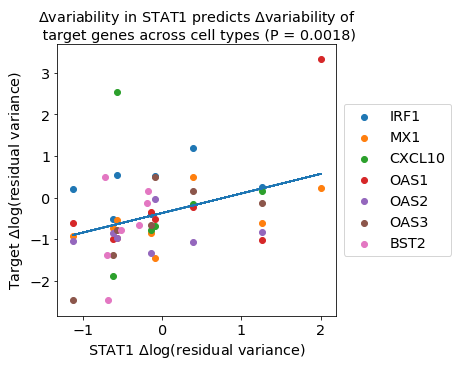

In [351]:
plt.figure(figsize=(5, 5))
plt.scatter(stat1_dv_diff, irf1_dv_diff, label='IRF1')
plt.scatter(stat1_dv_diff, mx1_dv_diff, label='MX1')
plt.scatter(stat1_dv_diff, cxcl10_dv_diff, label='CXCL10')
plt.scatter(stat1_dv_diff, oas1_dv_diff, label='OAS1')
plt.scatter(stat1_dv_diff, oas2_dv_diff, label='OAS2')
plt.scatter(stat1_dv_diff, oas3_dv_diff, label='OAS3')
plt.scatter(bst2_dv_diff, oas3_dv_diff, label='BST2')

plt.legend(bbox_to_anchor=(1,0.5),loc='center left')
x = np.tile(stat1_dv_diff, 7)
y = np.concatenate([irf1_dv_diff, mx1_dv_diff, cxcl10_dv_diff, oas1_dv_diff, oas2_dv_diff, oas3_dv_diff, bst2_dv_diff])
m, b, r, pval, _ = robust_linregress(x, y)
plt.plot(x, b+m*x, '-')
plt.xlabel('STAT1 $\Delta$log(residual variance)')
plt.ylabel('Target $\Delta$log(residual variance)')
plt.title('$\Delta$variability in STAT1 predicts $\Delta$variability of\n target genes across cell types (P = {:.4f})'.format(pval))

### Magnitude of correlation and covariance between STAT1 and downstream genes increases upon IFN-B stimulation

In [11]:
cts = ['CD4 T cells', 'CD8 T cells', 'B cells', 'CD14+ Monocytes', 'NK cells', 'FCGR3A+ Monocytes']
tfs = ['JUN',
    'ATF3',
    'STAT1',
    'STAT4',
    'FOXP1',
    'ATF6B',
    'ATF1',
    'STAT2',
    'STAT6',
    'FOS',
    'BATF',
    'AATF',
    'STAT3',
    'JUNB',
    'JUND',
    'ATF5',
    'ATF4']

0.6646057715835676
1.1204947044106595
1.6961175254412488
2.399526457117086
0.7047580691532214
3.9617469142331947


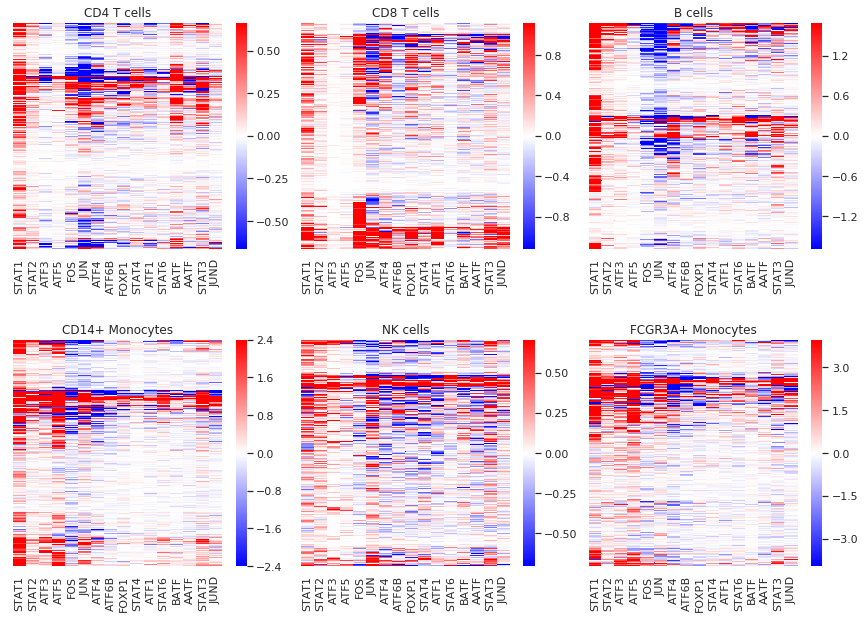

In [23]:
switch_genes_dict = {}
sns.set(font_scale=1)
plt.figure(figsize=(15, 10));
plt.subplots_adjust(hspace=0.4, wspace=0.1)
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)

    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)

    heatmap = np.abs(stim_2d_dict['cov_2']) - np.abs(stim_2d_dict['cov_1'])
    heatmap[~np.isfinite(heatmap)] = 0

    perc = np.percentile(np.abs(heatmap).ravel(), 90)
    print(perc)
    heatmap[heatmap < -perc] = -perc
    heatmap[heatmap > perc] = perc
    heatmap = pd.DataFrame(heatmap.T, columns=tfs, index=immune_genes)#[['STAT1', 'FOS']]

    
    switch_genes = heatmap.query('STAT1 > 0 & STAT2 > 0 & FOS < 0 & JUN < 0').index.tolist()
    switch_genes_dict[ct] = switch_genes.copy()
    order_nonswitch = sns.clustermap(heatmap.loc[~heatmap.index.isin(switch_genes),:], cmap='RdBu', center=0).dendrogram_row.reordered_ind; plt.close()
    order_nonswitch = heatmap.loc[~heatmap.index.isin(switch_genes), heatmap.columns != 'JUNB'].index[order_nonswitch].tolist()

    order_switch = sns.clustermap(heatmap.loc[heatmap.index.isin(switch_genes), :], cmap='RdBu', center=0).dendrogram_row.reordered_ind; plt.close()
    order_switch = heatmap.loc[heatmap.index.isin(switch_genes), heatmap.columns != 'JUNB'].index[order_switch].tolist()

    sns.heatmap(
        heatmap.loc[
            order_switch+order_nonswitch, 
            ['STAT1', 'STAT2', 'ATF3','ATF5','FOS', 'JUN','ATF4', 'ATF6B', 'FOXP1', 'STAT4', 'ATF1', 'STAT6', 'BATF', 'AATF', 'STAT3', 'JUND']
        ], 
        cmap='bwr', center=0, xticklabels=1)

    plt.gca().get_yaxis().set_visible(False)
    plt.title(ct)
sns.set()


### Scatter plot form

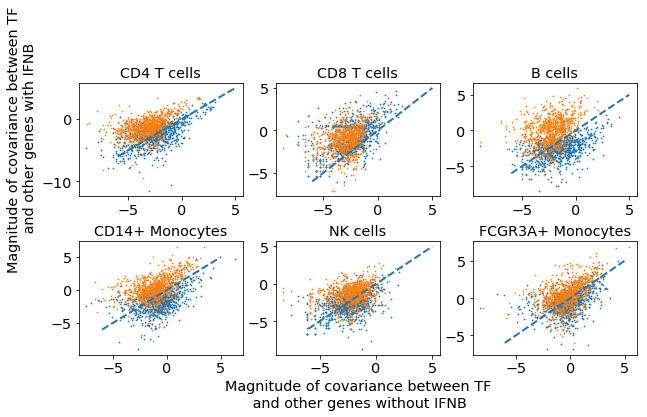

In [127]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)

for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)
            
    plt.scatter(
        np.log(np.abs(stim_2d_dict['cov_1'][9, :])),
        np.log(np.abs(stim_2d_dict['cov_2'][9, :])),
        s=0.5
    )

    plt.scatter(
        np.log(np.abs(stim_2d_dict['cov_1'][2, :])),
        np.log(np.abs(stim_2d_dict['cov_2'][2, :])),
        s=0.5
    )
    
    plt.plot([-6, 5], [-6, 5], '--', lw=2)
    
    
    plt.title(ct)

    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between TF\n and other genes without IFNB')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Magnitude of covariance between TF\n and other genes with IFNB')

In [156]:
for ct in cts:
    print('\'' + ct + '\':')

'CD4 T cells':
'CD8 T cells':
'B cells':
'CD14+ Monocytes':
'NK cells':
'FCGR3A+ Monocytes':


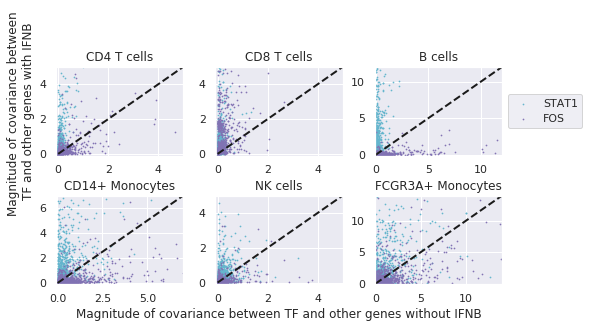

In [24]:
plt.figure(figsize=(8, 4));
plt.subplots_adjust(hspace=0.45, wspace=0.25)

max_vals = {
    'CD4 T cells':5,
    'CD8 T cells':5,
    'B cells':12,
    'CD14+ Monocytes':7,
    'NK cells':5,
    'FCGR3A+ Monocytes':14,
}

for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)
        
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][2, :]),
        np.abs(stim_2d_dict['cov_2'][2, :]),
        s=0.5,
        label='STAT1',
        color='c'
    )
    
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][9, :]),
        np.abs(stim_2d_dict['cov_2'][9, :]),
        s=0.5,
        label='FOS',
        color='m'
    )


    plt.plot([0, max_vals[ct]], [0, max_vals[ct]], '--', lw=2, c='k')
    plt.ylim(-.1, max_vals[ct])
    plt.xlim(-.1, max_vals[ct])
    
    
    plt.title(ct)
    
    if ct == 'B cells':
        plt.legend(bbox_to_anchor=(1,0.5),loc='center left')


    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between TF and other genes without IFNB')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Magnitude of covariance between \nTF and other genes with IFNB')

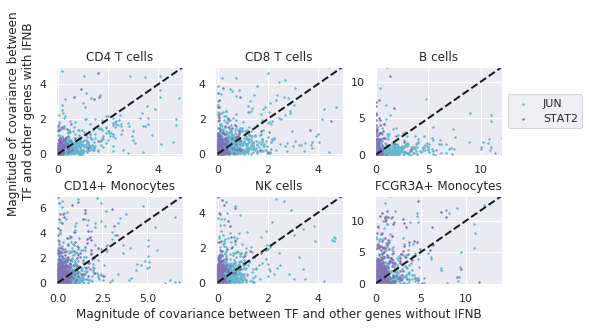

In [26]:
plt.figure(figsize=(8, 4));
plt.subplots_adjust(hspace=0.45, wspace=0.25)

max_vals = {
    'CD4 T cells':5,
    'CD8 T cells':5,
    'B cells':12,
    'CD14+ Monocytes':7,
    'NK cells':5,
    'FCGR3A+ Monocytes':14,
}

for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)
        
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][0, :]),
        np.abs(stim_2d_dict['cov_2'][0, :]),
        s=2,
        label='JUN',
        color='c'
    )
    
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][7, :]),
        np.abs(stim_2d_dict['cov_2'][7, :]),
        s=2,
        label='STAT2',
        color='m'
    )


    plt.plot([0, max_vals[ct]], [0, max_vals[ct]], '--', lw=2, c='k')
    plt.ylim(-.1, max_vals[ct])
    plt.xlim(-.1, max_vals[ct])
    
    
    plt.title(ct)
    
    if ct == 'B cells':
        plt.legend(bbox_to_anchor=(1,0.5),loc='center left')


    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between TF and other genes without IFNB')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Magnitude of covariance between \nTF and other genes with IFNB')

### Network drawing

In [27]:
ct = 'CD14+ Monocytes'
with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
    stim_2d_dict = pkl.load(f)

In [28]:
import networkx as nx
tfs_considered = ['STAT1', 'STAT2','FOS', 'JUN',]
genes_considered = switch_genes_dict[ct]#[:15]

In [29]:
len(genes_considered)

193

In [30]:
# Create the control graph
ctrl_df = pd.DataFrame(np.abs(stim_2d_dict['cov_1']).T, columns=tfs, index=immune_genes)
ctrl_G = nx.Graph()
ctrl_G.add_nodes_from(tfs_considered + genes_considered)
for tf in tfs_considered:
    for gene in genes_considered:
        ctrl_G.add_edge(tf, gene, weight=ctrl_df.loc[gene, tf])

# Create the stim graph
stim_df = pd.DataFrame(np.abs(stim_2d_dict['cov_2']).T, columns=tfs, index=immune_genes)
stim_G = nx.Graph()
stim_G.add_nodes_from(tfs_considered + genes_considered)
for tf in tfs_considered:
    for gene in genes_considered:
        stim_G.add_edge(tf, gene, weight=stim_df.loc[gene, tf])

In [48]:
# Generate the positions
pos = {}
for tf_idx, tf in enumerate(tfs_considered):
    pos[tf] = np.array([np.random.uniform(-7, -5), np.random.uniform(-6, 6)]) if tf_idx < len(tfs_considered)/2 else np.array([np.random.uniform(5, 7), np.random.uniform(-6, 6)])
for gene in genes_considered:
    if gene in tfs_considered:
        continue
    pos[gene] = np.array([np.random.uniform(-2, 2), np.random.uniform(-10, 10)])

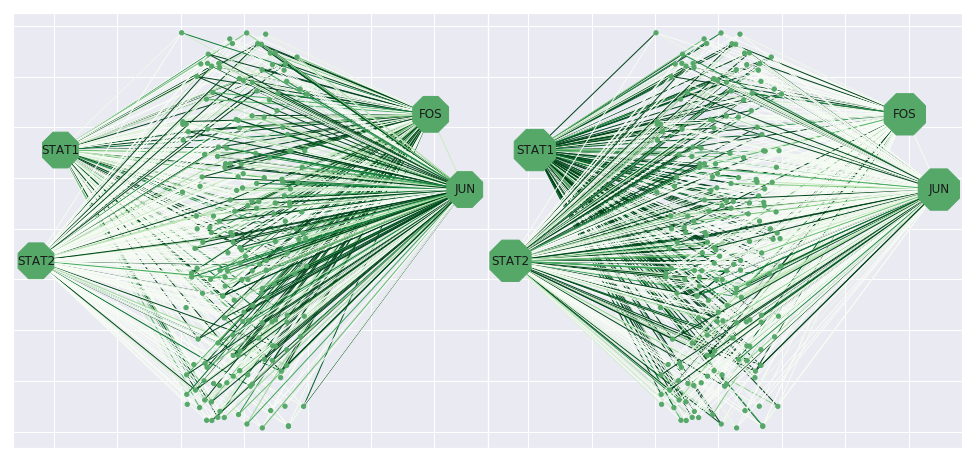

In [49]:
plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0)

edge_colors = np.array([ctrl_G[u][v]['weight'] for u,v in ctrl_G.edges])
nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    with_labels=True, 
    width=1, 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=[1500 for i in range(len(tfs_considered))] + [20 for i in range(len(genes_considered))],
    edge_vmin=0.3, 
    edge_vmax=1,
    node_color='g',
    node_shape='8',
    labels={tf:tf for tf in tfs_considered})

plt.subplot(1, 2, 2)
edge_colors = np.array([stim_G[u][v]['weight'] for u,v in stim_G.edges])
nx.draw_networkx(
    stim_G, 
    pos=pos, 
    with_labels=True, 
    width=1, 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=[2000 for i in range(len(tfs_considered))] + [20 for i in range(len(genes_considered))],
    edge_vmin=0.3, 
    edge_vmax=1,
    node_shape='8',
    node_color='g',
    labels={tf:tf for tf in tfs_considered})
#plt.title('IFNB Stimluation')

### Check 1D Hypothesis tests of the TFs

In [209]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    stim_1d_dict = pkl.load(f)

In [224]:
ct = 'CD14+ Monocytes'

In [225]:

list(zip(
    tfs,
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr'][tf_gene_idxs],
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff'][tf_gene_idxs],
))

[('JUN', 0.5986283747826544, -0.19030852778382057),
 ('ATF3', 0.6319349018990368, -0.2959004839166216),
 ('STAT1', 0.12954838779105596, -0.6201531885767011),
 ('STAT4', 0.982612418341671, -0.0008278366735992027),
 ('FOXP1', 0.9957395490722011, 0.023240353370100664),
 ('ATF6B', 0.7039342753747619, 0.3741452847156555),
 ('ATF1', 0.703412311398482, -0.23873828772843636),
 ('STAT2', 0.17261273222121118, -1.5032448384964125),
 ('STAT6', 0.43451690982836505, 0.5205212516790636),
 ('FOS', 0.11462055049275315, -0.6892570852905682),
 ('BATF', 0.8403839373539934, 0.5757373873554044),
 ('AATF', 0.9668329607373896, -0.03200797422934443),
 ('STAT3', 0.6538877375618506, -0.3151068448403085),
 ('JUNB', 0.7990490362827087, 0.07684280103591856),
 ('JUND', 0.3127015311805658, 0.5627964791710258),
 ('ATF5', 0.28676822481880004, -0.3955897268957598),
 ('ATF4', 0.7729121556753094, 0.2098264308075889)]

In [221]:
list(zip(
    tfs,
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr'][tf_gene_idxs],
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff'][tf_gene_idxs],
))

[('JUN', 0.4329414424151314, 0.15594905614852905),
 ('ATF3', 1.0, inf),
 ('STAT1', 1.3911895181856716e-05, 2.0702450275421143),
 ('STAT4', 0.5315262862119486, -0.1619182825088501),
 ('FOXP1', 0.00038928767104798355, -0.786072850227356),
 ('ATF6B', 0.11455621113854228, -0.33576536178588867),
 ('ATF1', 0.6342395520165257, -0.20917117595672607),
 ('STAT2', 7.998374125940433e-06, 2.585352897644043),
 ('STAT6', 0.7338129780169744, 0.2435469627380371),
 ('FOS', 0.5772411690059589, -0.39830708503723145),
 ('BATF', 0.31458922351405944, 0.3176548480987549),
 ('AATF', 0.001129408987101406, -0.6960010528564453),
 ('STAT3', 0.00024595784988556605, 0.823617160320282),
 ('JUNB', 0.5520187210197149, -0.08636486530303955),
 ('JUND', 0.6358756719128248, 0.1947563886642456),
 ('ATF5', 0.5131427893623288, 0.53122878074646),
 ('ATF4', 0.40875170846433856, -0.28597116470336914)]

### Covariance distribution shifts

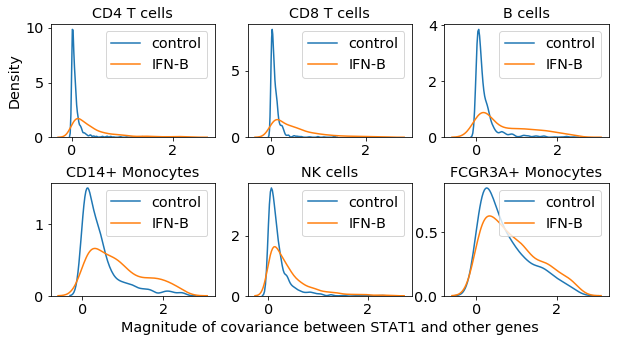

In [383]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)
gene_idx = 0 # referring to STAT1
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][gene_idx, :]), limit=2.5, hist=False, label='control')
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][gene_idx, :]), limit=2.5, hist=False, label='IFN-B')
    plt.title(ct);
    
    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between STAT1 and other genes')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Density')

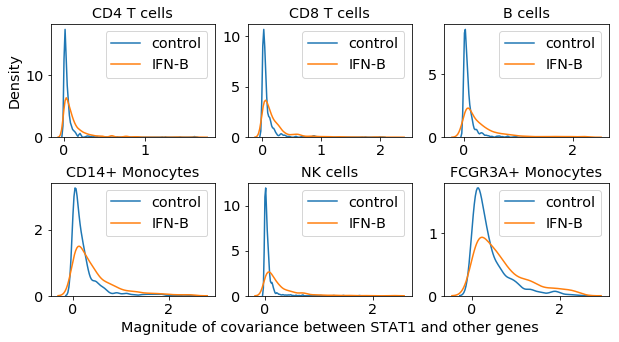

In [679]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)
gene_idx = 1 # referring to STAT1
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][gene_idx, :]), limit=2.5, hist=False, label='control')
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][gene_idx, :]), limit=2.5, hist=False, label='IFN-B')
    plt.title(ct);
    
    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between STAT1 and other genes')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Density')

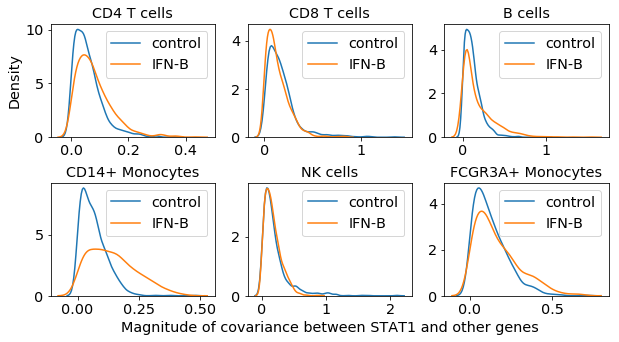

In [384]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)
gene_idx = 0 # referring to STAT1
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][gene_idx, :]), limit=2.5, hist=False, label='control')
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][gene_idx, :]), limit=2.5, hist=False, label='IFN-B')
    plt.title(ct);
    
    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between STAT1 and other genes')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Density')

### Get a list of TFs

In [21]:
len("""JUN
ATF3
STAT1
STAT4
FOXP1
ATF6B
ATF1
STAT2
STAT6
FOS
BATF
AATF
STAT3
JUNB
JUND
ATF5
ATF4""".split())

17

In [19]:
for gene in adata.var.index:
    if ('JUN' in gene or 'ATF' in gene or 'FO' in gene or 'STAT' in gene):
        print(gene)

JUN
ATF3
STAT1
STAT4
FOXP1
ATF6B
ATF1
STAT2
STAT6
FOS
BATF
AATF
STAT3
JUNB
JUND
ATF5
ATF4


In [177]:
tfs = pd.read_csv('gene_attribute_matrix.txt', sep='\t').columns.tolist()[3:]
tfs_in_highcount = set(tfs) & set(adata.var.index)

In [178]:
tfs_in_highcount = list(set(tfs) & set(adata.var.index))

In [179]:
with open(data_path + 'tfs_to_consider.pkl', 'wb') as f:
    pkl.dump(tfs_in_highcount, f)

In [195]:
import random
random.shuffle(tfs_in_highcount)

In [198]:
tfs_in_highcount[:30]

['RAD21',
 'CEBPB',
 'STAT1',
 'SMARCB1',
 'CEBPZ',
 'H2AFZ',
 'IRF1',
 'BDP1',
 'FOS',
 'YY1',
 'MEF2A',
 'IRF3',
 'HMGN3',
 'BHLHE40',
 'GATA3',
 'SMARCC1',
 'ATF1',
 'BATF',
 'MAX',
 'SMC3',
 'HDAC2',
 'NELFE',
 'ETS1',
 'IKZF1',
 'CBX3',
 'HSF1',
 'BCLAF1',
 'SPI1',
 'REST',
 'BACH1']

In [180]:
len(tfs_in_highcount)

56

In [45]:
with open(data_path + 'stim_effect_2d_highcount_tfs.pkl', 'rb') as f:
    temp = pkl.load(f)

In [56]:
temp[('CD14+ Monocytes - ctrl','CD14+ Monocytes - stim')]['gene_idx_1']

array([3263])

(array([  1.,   2.,   4.,   3.,  46.,  31.,   7., 135., 242., 384.]),
 array([6.99730736e-04, 1.00579763e-01, 2.00459795e-01, 3.00339827e-01,
        4.00219858e-01, 5.00099890e-01, 5.99979922e-01, 6.99859954e-01,
        7.99739986e-01, 8.99620018e-01, 9.99500050e-01]),
 <a list of 10 Patch objects>)

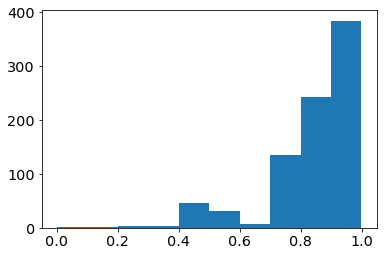

In [54]:
plt.hist(temp[('CD14+ Monocytes - ctrl','CD14+ Monocytes - stim')]['dcov_fdr'].ravel())

In [44]:
for tf in tfs_in_highcount:
    if 'STAT' in tf:
        print(tf)

STAT3
STAT2
STAT1


### Differential correlation/covariance for STAT proteins

In [495]:
with open(data_path + 'stim_effect_2d_ifn_pathway.pkl', 'rb') as f:
    stim_2d_ifn_pathway = pkl.load(f)


In [512]:
def reindex(gene):
    return np.where(stim_2d_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2'] == adata.var.index.tolist().index(gene))[0][0]

def build_dc_df(ct, tf_idx, result_dict):
    
    df = pd.DataFrame()
    df['gene_idx'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
    df['gene'] = adata.var.index[result_dict[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']]
    
    df['cov_1'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][tf_idx, :]
    df['cov_2'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][tf_idx, :]
    
    df['cov_1'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][tf_idx, :]
    df['cov_2'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][tf_idx, :]
    
    df['corr_fdrs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcorr_fdr'][tf_idx, :]
    df['corr_diffs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcorr_diff'][tf_idx, :]
    df['cov_fdrs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcov_fdr'][tf_idx, :]
    df['cov_diffs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcov_diff'][tf_idx, :]
    
    
    return df

### Covariance matrices

In [514]:
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=100000,
    beta=0.1)

estimator.estimate_beta_sq(tolerance=3)
estimator.estimate_parameters()

Computing observed moments for: CD14+ Monocytes - ctrl
Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: Dendritic cells - ctrl
Computing observed moments for: NK cells - ctrl
Computing observed moments for: CD8 T cells - ctrl
Computing observed moments for: B cells - ctrl
Computing observed moments for: Megakaryocytes - ctrl
Computing observed moments for: FCGR3A+ Monocytes - ctrl
Computing observed moments for: CD8 T cells - stim
Computing observed moments for: Dendritic cells - stim
Computing observed moments for: B cells - stim
Computing observed moments for: CD4 T cells - stim
Computing observed moments for: CD14+ Monocytes - stim
Computing observed moments for: Megakaryocytes - stim
Computing observed moments for: NK cells - stim
Computing observed moments for: FCGR3A+ Monocytes - stim


In [536]:
adata.var.index[pathway_gene_idxs]

Index(['OAS1', 'OAS2', 'OAS3', 'MX1', 'IRF1', 'CXCL10', 'BST2', 'IFNAR1',
       'IFNAR2'],
      dtype='object', name='index')

In [579]:
pathway_gene_idxs = np.array([2394, 2396, 2395, 3582, 1060,  914, 3326])
stat_gene_idxs = np.array([ 587, 2322, 2969])
all_gene_idxs = np.concatenate([pathway_gene_idxs, stat_gene_idxs])

In [606]:
ct = 'CD4 T cells'

In [609]:
stat1_mat = np.abs(np.vstack([
    estimator.parameters[ct + ' - ctrl']['corr'][0, :][:, pathway_gene_idxs], 
    estimator.parameters[ct + ' - stim']['corr'][0, :][:, pathway_gene_idxs]]).T)
stat1_mat = pd.DataFrame(stat1_mat, columns=['ctrl', 'stim'], index=adata.var.index[pathway_gene_idxs])

In [665]:
stats.pearsonr(
    adata[adata.obs.cell_type=='CD4 T cells - stim', :][:, 'STAT1'].X, 
    adata[adata.obs.cell_type=='CD4 T cells - stim', :][:, 'OAS3'].X,)

(0.031039041308293974, 0.02481444717075514)

In [646]:
ct = 'CD4 T cells'

In [648]:
estimator.parameters[ct + ' - stim']['corr'][0, :][:, pathway_gene_idxs]

matrix([[-0.16645536, -0.08849825, -0.02453642, -0.03642451, -0.02169104,
         -0.03878952, -0.14220214]])

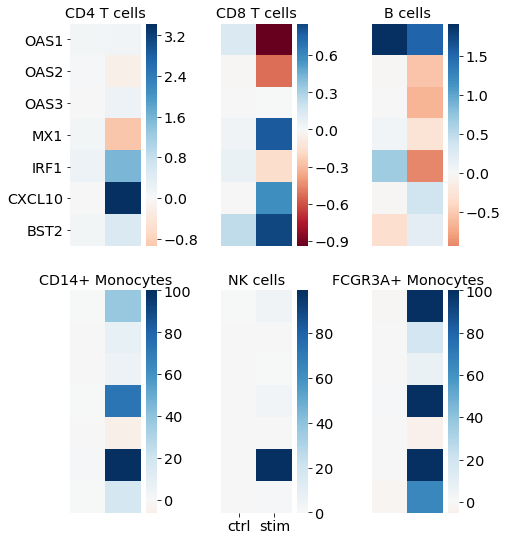

In [676]:
max_val = 100
plt.figure(figsize=(7, 9));
plt.subplots_adjust(wspace=0.7)

for ct_idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'B cells', 'CD14+ Monocytes', 'NK cells', 'FCGR3A+ Monocytes']):
    
    stat1_mat = np.vstack([
        estimator.parameters[ct + ' - ctrl']['cov'][1, :][:, pathway_gene_idxs], 
        estimator.parameters[ct + ' - stim']['cov'][1, :][:, pathway_gene_idxs]]).T
    stat1_mat[stat1_mat > max_val] = max_val
    stat1_mat[stat1_mat < -max_val] = -max_val
    stat1_mat = pd.DataFrame(stat1_mat, columns=['ctrl', 'stim'], index=adata.var.index[pathway_gene_idxs])
    stat1_mat.index.name = 'IFN Pathway genes'

    plt.subplot(2, 3, ct_idx+1)
    ax = sns.heatmap(stat1_mat, cmap='RdBu', center=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if ct != 'NK cells':
        ax.get_xaxis().set_visible(False)
    if ct != 'CD4 T cells':
        ax.get_yaxis().set_visible(False)
    plt.title(ct)


In [564]:
sns.heatmap(estimator.parameters[ct + ' - ctrl']['corr'][0, :][:, pathway_gene_idxs] cmap='Reds')

SyntaxError: invalid syntax (<ipython-input-564-df3df3b8768c>, line 1)

In [554]:
ctrl_cov_mat = estimator.parameters[ct + ' - ctrl']['corr'][all_gene_idxs, :][:, all_gene_idxs]
ctrl_cov_mat[ctrl_cov_mat > 500] = np.nan
ctrl_cov_mat[~np.isfinite(ctrl_cov_mat)] = 0

stim_cov_mat = estimator.parameters[ct + ' - stim']['corr'][all_gene_idxs, :][:, all_gene_idxs]
stim_cov_mat[stim_cov_mat > 30] = np.nan
stim_cov_mat[~np.isfinite(stim_cov_mat)] = 0

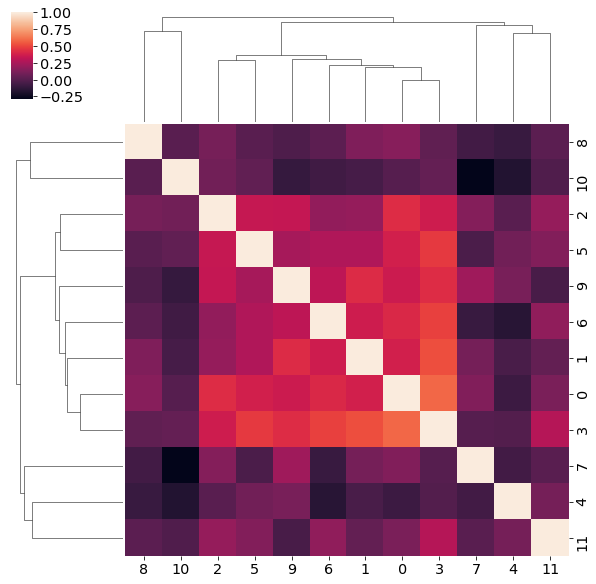

In [555]:
sns.clustermap(stim_cov_mat)

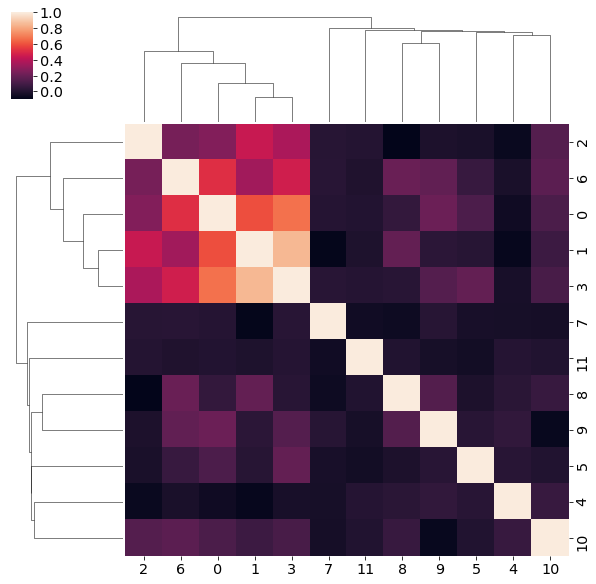

In [556]:
sns.clustermap(ctrl_cov_mat)

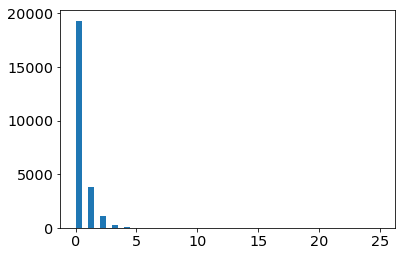

In [505]:
plt.hist(adata[:, 'STAT1'].X, bins=50);

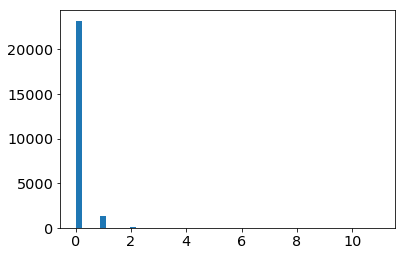

In [507]:
plt.hist(adata[:, 'IFNAR1'].X, bins=50);

In [680]:
for ct in adata.obs.cell.drop_duplicates():
    
    print(ct)
    a = build_dc_df(ct, 0, stim_2d_ifn_pathway).query('gene == "IFNAR1"')
    if len(a) > 0:
        print(a)


CD14+ Monocytes
   gene_idx    gene     cov_1     cov_2  corr_fdrs  corr_diffs  cov_fdrs  \
7  3564      IFNAR1  0.202026  1.185078  0.228842   0.201133    0.305174   

   cov_diffs  
7  0.983052   
CD4 T cells
   gene_idx    gene    cov_1     cov_2  corr_fdrs  corr_diffs  cov_fdrs  \
7  3564      IFNAR1  0.06083  0.130479  0.8768    -0.036203    0.857706   

   cov_diffs  
7  0.069649   
Dendritic cells
   gene_idx    gene     cov_1     cov_2  corr_fdrs  corr_diffs  cov_fdrs  \
7  3564      IFNAR1 -2.396321  3.937598  0.493915   0.720429    0.250827   

   cov_diffs  
7  6.333919   
NK cells
   gene_idx    gene     cov_1     cov_2  corr_fdrs  corr_diffs  cov_fdrs  \
7  3564      IFNAR1 -0.098419 -0.014315  0.545595   0.251716    0.893202   

   cov_diffs  
7  0.084104   
CD8 T cells
   gene_idx    gene     cov_1     cov_2  corr_fdrs  corr_diffs  cov_fdrs  \
7  3564      IFNAR1  0.042537 -0.578717  0.514283  -0.49442     0.161728   

   cov_diffs  
7 -0.621254   
B cells
   gene_idx   

In [455]:
set(stim_2d_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2']) == set(stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2'])

True

In [449]:
stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2']

array([3025,  565, 1418, 2902, 1354, 1893, 1955, 2638, 3284, 2104])

In [454]:
'CD300E' in immune_genes

True

In [453]:
adata.var.index.tolist()[3025]

'CD300E'

In [452]:
adata.var.index.tolist().index('VAMP3')

21

In [451]:
immune_genes[:5]

['VAMP3', 'KLF2', 'SIRPA', 'GPR65', 'CEBPG']

In [460]:
with open(data_path + 'stim_effect_2d_cd8.pkl', 'rb') as f:
    temp = pkl.load(f)
with open(data_path + 'stim_effect_2d.pkl', 'rb') as f:
    temp2 = pkl.load(f)

In [470]:
np.where(stim_2d_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2'] == 3025)

(array([629]),)

In [472]:
stim_2d_dict[('CD4 T cells - ctrl',
  'CD4 T cells - stim')]['dcorr_diff'][:, 629]

array([-0.01339798,  0.07437548, -0.12383287,  0.03304237,  0.06906411,
        0.09330619])

In [473]:
temp2[('CD4 T cells - ctrl',
  'CD4 T cells - stim')]['dcorr_diff'][:, 0]

array([-0.01339798,  0.07437548, -0.12383287,  0.03304237,  0.06906411,
        0.09330619])

In [459]:
temp[('CD8 T cells - ctrl', 'CD8 T cells - stim')]['gene_idx_2']

array([  21, 3320, 3123, 2600, 3350, 1602,  749, 1665, 1349, 2606, 2552,
       2554,  513, 2944, 2493, 2154, 3206, 1831, 2764,  447,   16, 2784,
       2938,  722,   38,  170, 1640, 3485,  869,  583,   32, 2242, 3539,
       1325,  799, 1797,  208, 2455,  209,  957, 3121, 2981, 2905, 3047,
       2587, 1483, 1700,  324, 1376, 1902,  737, 1321, 1905, 1216,  908,
        783,  940, 2820, 1357, 2123,  340,  926, 1398,  721, 1189, 3119,
       3183,  767,  580, 1549,  564, 3445, 1414, 2165,  692, 1601, 3458,
       1025, 1111, 3283, 2245,  505, 1005, 1144,  976, 3084, 1038,  111,
         92, 2156, 3050,  197,  243, 3500, 3562, 2725, 3439, 3386, 3459,
        808, 1763, 1252, 1861, 2396,  372, 1359, 2038, 1188,  217, 1185,
        164, 2748, 2792, 1834,  218, 2284, 2612, 1008, 1789,  719, 3449,
       1023, 1830,  936, 3087,  174, 2580, 3399,  115,  603, 3228, 1624,
       3563, 2335, 3187,  708, 2571, 1515, 1791, 2076, 1277,  194, 1174,
       2710, 1337, 1201, 2300, 3432, 1066, 3092, 19

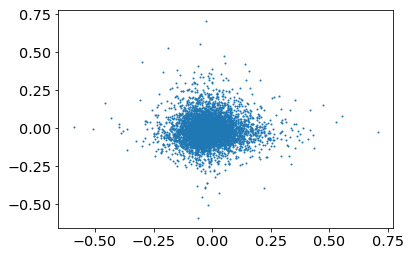

In [442]:
plt.scatter(
    stim_2d_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['corr_1'].ravel(),
    stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['corr_1'].ravel(),
    s=1
)

In [436]:
stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcorr_diff'][:5, :5]

array([[-0.01339798,  0.04006225,  0.08417496,  0.14702904, -0.10544408],
       [ 0.07437548, -0.14681412, -0.1596377 , -0.03469869,  0.15192714],
       [-0.12383287, -0.07240015,  0.14711209, -0.09062913,  0.00078449],
       [ 0.03304237,  0.09341762,  0.03684757,  0.18442113, -0.14015532],
       [ 0.06906411, -0.05053621, -0.05156865,  0.13397507, -0.02526662]])

In [424]:
build_dc_df('CD4 T cells', 1).query('corr_fdrs < 0.1 | cov_fdrs < 0.1')

,gene,corr_fdrs,corr_diffs,cov_fdrs,cov_diffs
12,ARID5A,2.648681e-01,-0.213039,5.123488e-02,-0.791319
53,HLA-DMA,1.461019e-04,0.438751,6.947654e-07,0.103530
71,FPR3,1.000000e+00,NaN,1.066434e-04,-0.004874
88,RNF19B,3.031910e-01,-0.041049,4.736100e-04,-0.011410
93,HMOX1,3.170713e-06,-0.072791,6.927342e-04,-0.015066
102,FCN1,1.563514e-01,-0.073168,6.947654e-07,-0.049075
143,CTSH,1.350606e-04,0.227851,3.797408e-01,0.060815
155,IL27,1.000000e+00,NaN,1.937649e-04,-0.007311
185,TNFAIP6,5.487769e-03,-0.072423,6.175563e-04,-0.017392
203,RAB32,3.407659e-01,-0.039945,6.927342e-04,-0.012186


In [385]:
def reindex(gene):
    return np.where(stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2'] == adata.var.index.tolist().index(gene))[0][0]

def build_dc_df(ct, tf_idx):
    
    df = pd.DataFrame()
    df['gene'] = adata.var.index[stim_dc_dict[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']]

    df['corr_fdrs'] = stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcorr_fdr'][tf_idx, :]
    df['corr_diffs'] = stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcorr_diff'][tf_idx, :]
    df['cov_fdrs'] = stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcov_fdr'][tf_idx, :]
    df['cov_diffs'] = stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcov_diff'][tf_idx, :]
    

    return df

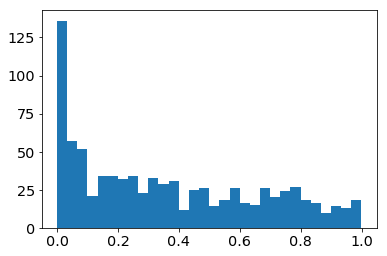

In [181]:
plt.hist(stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcov_pval'][0, :], bins=30);

In [165]:
adata.var.index[stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2'][251]]

'MX1'

In [262]:
stat1_dc_gnes = build_dc_df(0).query('corr_fdrs < 0.2 | cov_fdrs < 0.1').gene.tolist()

In [263]:
stat1_dc_genes_dv = [stim_1d_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dv_diff'][adata.var.index.tolist().index(gene)] for gene in stat1_dc_gnes]

In [275]:
np.array(stat1_dc_genes_dv).mean()

0.05799960612344061

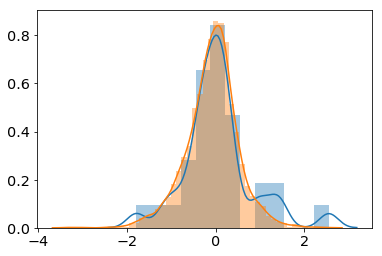

In [273]:
sns.distplot(stat1_dc_genes_dv)
robust_hist(stim_1d_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dv_diff'])

In [237]:
stat3_dc_genes = build_dc_df(2).query('corr_fdrs < 0.15 | cov_fdrs < 0.1').gene.tolist()
stat1_dc_genes = build_dc_df(0).query('corr_fdrs < 0.15 | cov_fdrs < 0.1').gene.tolist()

In [ ]:
stat

In [141]:
reindex('CXCL10')

404

In [140]:
stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcorr_diff'].shape

(6, 855)

In [ ]:
(stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcorr_fdr'][0, :] < 0.1)

(array([  9.,  14.,  15.,  14.,  30.,  24.,  93., 113., 231., 312.]),
 array([9.82559947e-05, 1.00088430e-01, 2.00078605e-01, 3.00068779e-01,
        4.00058954e-01, 5.00049128e-01, 6.00039302e-01, 7.00029477e-01,
        8.00019651e-01, 9.00009826e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

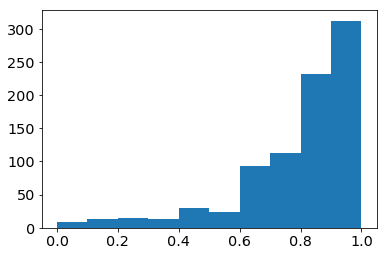

In [163]:
plt.hist(stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dcorr_fdr'][2, :])

In [121]:
robust_linregress(stat1_dv_diff, irf1_dv_diff)

-1.1263139314212716


LinregressResult(slope=0.22145049912015483, intercept=0.28503241271664365, rvalue=0.295707607525227, pvalue=0.5196487865298648, stderr=0.31993309454536795)

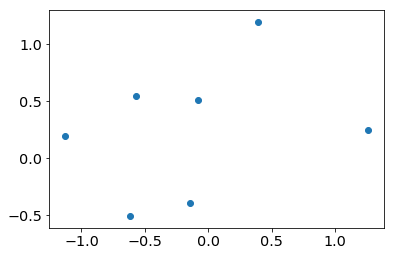

In [122]:
plt.scatter(stat1_dv_diff, irf1_dv_diff)
#plt.scatter(stat1_dv_diff, mx1_dv_diff)

In [269]:
for key in stim_1d_dict:
    print(key, stim_1d_dict[key]['dv_fdr'][adata.var.index.tolist().index('STAT1')])

('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim') 0.12362915532387027
('CD4 T cells - ctrl', 'CD4 T cells - stim') 0.1544700949556428
('Dendritic cells - ctrl', 'Dendritic cells - stim') 0.9961347237111365
('NK cells - ctrl', 'NK cells - stim') 0.18966088763331118
('CD8 T cells - ctrl', 'CD8 T cells - stim') 0.4007703845923082
('B cells - ctrl', 'B cells - stim') 0.42525509322449534
('Megakaryocytes - ctrl', 'Megakaryocytes - stim') 0.49407053167026166
('FCGR3A+ Monocytes - ctrl', 'FCGR3A+ Monocytes - stim') 0.8589173225811922


In [276]:
for key in stim_1d_dict:
    print(key, stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('STAT1')])

('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim') -0.6201531885767011
('CD4 T cells - ctrl', 'CD4 T cells - stim') -0.568742954816007
('Dendritic cells - ctrl', 'Dendritic cells - stim') -0.08562693439030333
('NK cells - ctrl', 'NK cells - stim') -1.1263139314212716
('CD8 T cells - ctrl', 'CD8 T cells - stim') 0.38737933712795103
('B cells - ctrl', 'B cells - stim') 1.2535659861821071
('Megakaryocytes - ctrl', 'Megakaryocytes - stim') 1.9995983502257086
('FCGR3A+ Monocytes - ctrl', 'FCGR3A+ Monocytes - stim') -0.14216546964738708


In [257]:
stim_1d_dict[('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim')]['dv_diff'][adata.var.index.tolist().index('CXCL10')]

-1.88675062179433

In [253]:
gene_idx = 1
print(stat1_dc_genes[gene_idx])

for key in stim_1d_dict:
    print(
        key, 
        stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index(stat1_dc_genes[gene_idx])], 
        stim_1d_dict[key]['dv_fdr'][adata.var.index.tolist().index(stat1_dc_genes[gene_idx])])

CD40
('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim') 0.3266495132123043 0.40107655411467413
('CD4 T cells - ctrl', 'CD4 T cells - stim') 1.432437722060561 0.2030426058145504
('Dendritic cells - ctrl', 'Dendritic cells - stim') -0.4289617795351015 0.6537403398273498
('NK cells - ctrl', 'NK cells - stim') 1.165206840406023 0.13001479100852767
('CD8 T cells - ctrl', 'CD8 T cells - stim') -0.2228453478989736 0.5991247184119762
('B cells - ctrl', 'B cells - stim') 0.43555240071327894 0.6295186485126255
('Megakaryocytes - ctrl', 'Megakaryocytes - stim') -2.2668083517651993 0.0827056474743521
('FCGR3A+ Monocytes - ctrl', 'FCGR3A+ Monocytes - stim') 0.24543698978801398 0.7216974640399295


In [219]:
for key in stim_1d_dict:
    print(key, stim_1d_dict[key]['dv_diff'][adata.var.index.tolist().index('STAT3')])

('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim') -0.3151068448403085
('CD4 T cells - ctrl', 'CD4 T cells - stim') -0.22744479811589446
('Dendritic cells - ctrl', 'Dendritic cells - stim') -1.9010261881276111
('NK cells - ctrl', 'NK cells - stim') -0.3177004150141004
('CD8 T cells - ctrl', 'CD8 T cells - stim') 1.3431370327095618
('B cells - ctrl', 'B cells - stim') 0.8301385242016309
('Megakaryocytes - ctrl', 'Megakaryocytes - stim') 0.05353795497603775
('FCGR3A+ Monocytes - ctrl', 'FCGR3A+ Monocytes - stim') 0.5091610677554732


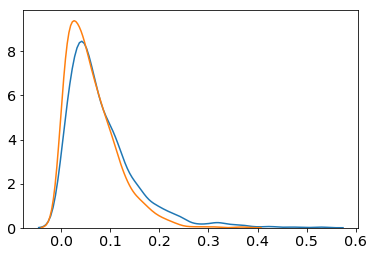

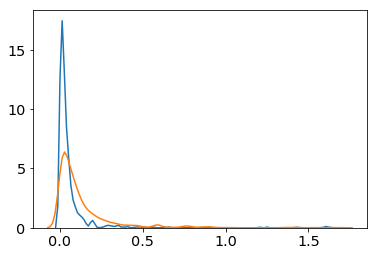

In [76]:
#for ct in adata.obs.cell.drop_duplicates():
   # plt.figure();
ct = 'CD4 T cells'
idx = 1
plt.figure();
robust_hist(np.abs(stim_dc_dict[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][idx, :]), limit=2, hist=False)
robust_hist(np.abs(stim_dc_dict[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][idx, :]), limit=2, hist=False)
plt.figure();
robust_hist(np.abs(stim_dc_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][idx, :]), limit=2, hist=False)
robust_hist(np.abs(stim_dc_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][idx, :]), limit=2, hist=False)

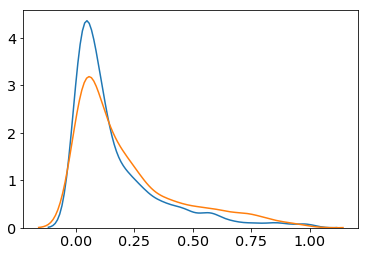

In [49]:
robust_hist(np.abs(stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['cov_1'][2, :]), limit=1, hist=False)
robust_hist(np.abs(stim_dc_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['cov_2'][2, :]), limit=1, hist=False)

In [23]:
estimator.estimate_parameters()

In [26]:
for ct in ['CD4 T cells']:#adata.obs['cell'].drop_duplicates().tolist():

		print('Correlation testing for', ct)
		start = time.time()
		estimator.compute_confidence_intervals_2d(
			gene_list_1=['STAT1', 'STAT2', 'STAT3'],
			gene_list_2=immune_genes,
			groups=[ct + ' - ctrl', ct + ' - stim'],
			groups_to_compare=[(ct + ' - ctrl', ct + ' - stim')],
            gene_tracker_count=500)
		print('This cell type took', time.time()-start)

Correlation testing for CD4 T cells
Computing the 0st/th gene of 2565
Computing the 500st/th gene of 2565
Computing the 2000st/th gene of 2565
Computing the 2500st/th gene of 2565
Computing the 3500st/th gene of 2565
Computing the 4000st/th gene of 2565
This cell type took 397.41969776153564


In [73]:
for ct in ['CD4 T cells']:#adata.obs['cell'].drop_duplicates().tolist():

		start = time.time()
		estimator.compute_confidence_intervals_1d(
			groups=[ct + ' - ctrl', ct + ' - stim'],
			groups_to_compare=[(ct + ' - ctrl', ct + ' - stim')],
            gene_tracker_count=500)

Computing the 0st/th gene
Computing the 500st/th gene
Computing the 1000st/th gene
Computing the 1500st/th gene
Computing the 2000st/th gene
Computing the 2500st/th gene
Computing the 3000st/th gene
Computing the 3500st/th gene


In [74]:
adata.var.index.tolist().index('STAT1')

587

In [80]:
estimator.hypothesis_test_result_1d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dv_diff'][adata.var.index.tolist().index('STAT1')]

-0.568742954816007

In [89]:
estimator.hypothesis_test_result_1d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dv_fdr'][adata.var.index.tolist().index('STAT3')]

0.7061707720759799

In [85]:
estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['cov_1'].shape

(3, 855)

In [34]:
estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['cov_1'].shape

(3, 855)

In [ ]:
stat1_ctrl_correlations = 

In [58]:
np.median(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['corr_1'][0, :])

nan

In [51]:
np.nanmedian(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['corr_2'][0, :])

-0.03307677243330215

In [54]:
robust_hist(np.abs(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['corr_1'][3, :]))
robust_hist(np.abs(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['corr_2'][3, :]))

NameError: name 'estimator' is not defined

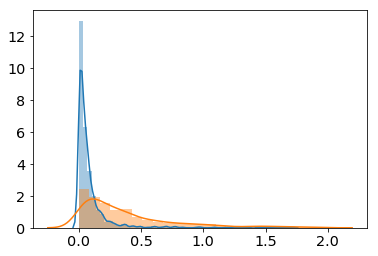

In [72]:
robust_hist(np.abs(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['cov_1'][0, :]), limit=2)
robust_hist(np.abs(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['cov_2'][0, :]), limit=2)

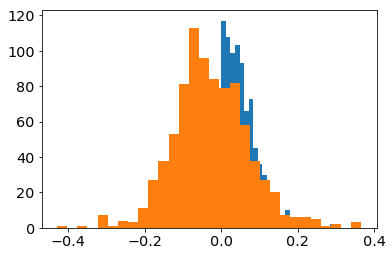

In [57]:
plt.hist(, bins=30);
plt.hist(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['corr_2'][0, :], bins=30);

#plt.hist(estimator.hypothesis_test_result_2d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['cov_2'][2, :], bins=30);
#plt.xlim(-2, 2)

### 1D effects

In [105]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    stim_delta_dict = pkl.load(f)

In [129]:
np.bincount(adata[adata.obs.cell_type == 'CD8 T cells - stim', :][:, 'STAT3'].X.astype(int))

array([853,  93,  10,   2,   1,   1])

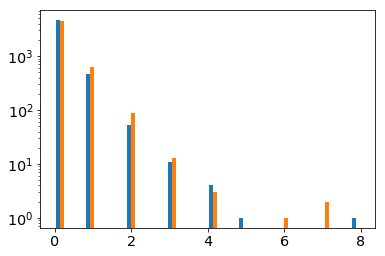

In [131]:
plt.hist(
    [adata[adata.obs.cell_type == 'CD4 T cells - ctrl', :][:, 'STAT3'].X,
     adata[adata.obs.cell_type == 'CD4 T cells - stim', :][:, 'STAT3'].X], bins=30, log=True);

In [132]:
for key in stim_delta_dict:
    print(key, stim_delta_dict[key]['dv_fdr'][adata.var.index.tolist().index('STAT3')])

('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim') 0.6543833013721241
('CD4 T cells - ctrl', 'CD4 T cells - stim') 0.7047044545320994
('Dendritic cells - ctrl', 'Dendritic cells - stim') 0.48896694793376866
('NK cells - ctrl', 'NK cells - stim') 0.7491844604979137
('CD8 T cells - ctrl', 'CD8 T cells - stim') 0.09398070103114066
('B cells - ctrl', 'B cells - stim') 0.20002524231499702
('Megakaryocytes - ctrl', 'Megakaryocytes - stim') 0.9727417817874321
('FCGR3A+ Monocytes - ctrl', 'FCGR3A+ Monocytes - stim') 0.6246332145927808


In [121]:
for key in stim_delta_dict:
    print(key, stim_delta_dict[key]['de_fdr'][adata.var.index.tolist().index('STAT3')])

('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim') 1.0308854193814017e-06
('CD4 T cells - ctrl', 'CD4 T cells - stim') 1.4397859915502101e-05
('Dendritic cells - ctrl', 'Dendritic cells - stim') 0.32907928100979966
('NK cells - ctrl', 'NK cells - stim') 4.72662700042497e-05
('CD8 T cells - ctrl', 'CD8 T cells - stim') 0.014501750781310904
('B cells - ctrl', 'B cells - stim') 5.812063080375114e-05
('Megakaryocytes - ctrl', 'Megakaryocytes - stim') 0.2737097973695478
('FCGR3A+ Monocytes - ctrl', 'FCGR3A+ Monocytes - stim') 0.0009408230918637007


In [110]:
stim_delta_dict

{('CD14+ Monocytes - ctrl',
  'CD14+ Monocytes - stim'): {'log_mean_1': array([-0.99468982, -2.29721355,  2.37025714, ..., -0.04592288,
         -1.35275221,  0.72669429]), 'log_mean_2': array([-1.94976342,  2.37990856,  7.05433369, ...,  0.6776402 ,
         -2.61624289,  0.98034626]), 'log_residual_var_1': array([0.08840082, 0.6624849 , 3.3160223 , ..., 0.62458296, 0.96231656,
         0.19126815]), 'log_residual_var_2': array([ 0.37866722,  1.01137235,  1.90659209, ...,  0.19125103,
          0.61152531, -0.12485809]), 'de_diff': array([-0.9550736 ,  4.67712212,  4.68407631, ...,  0.72356308,
         -1.26349068,  0.25365198]), 'de_pval': array([7.65152112e-06, 8.03179168e-09, 8.82987093e-08, ...,
         1.01567902e-07, 1.77453186e-05, 1.99996000e-04]), 'de_fdr': array([1.65514241e-05, 4.38497885e-07, 9.88340382e-07, ...,
         1.05168147e-06, 3.51288869e-05, 3.41046810e-04]), 'dv_diff': array([ 0.2902664 ,  0.34888746, -1.40943021, ..., -0.43333192,
         -0.35079124, -0.3

### Residual variance

In [23]:
estimator.estimate_parameters()

In [24]:
est_mean = np.concatenate([estimator.estimated_central_moments[ct]['first'] for ct in estimator.groups])
est_var = np.concatenate([estimator.estimated_central_moments[ct]['second'] for ct in estimator.groups])
est_disp = est_var/est_mean
est_cv = est_var/est_mean**2

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.03336931]


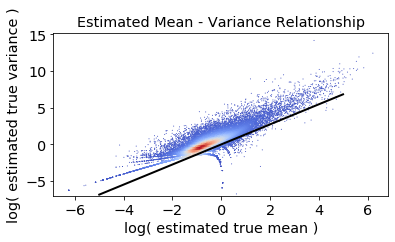

In [28]:
plt.figure(figsize=(6, 3))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var),
    s=1, 
    cmap='coolwarm')
x_fit = np.arange(-5, 5, 0.01)
y_fit = x_fit*estimator.mean_var_slope
plt.plot(x_fit, y_fit, color='k', lw=2)
plt.ylim(-7,)
plt.title('Estimated Mean - Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( estimated true variance )')
plt.savefig(data_path + 'figures/mean_vs_var.png', bbox_inches='tight')

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.0333693 ]


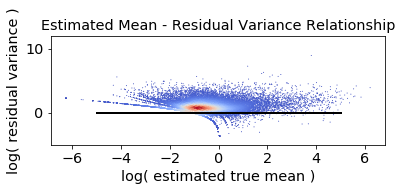

In [29]:
plt.figure(figsize=(6, 2))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var) - estimator.mean_var_slope*np.log(est_mean),
    s=1, 
    cmap='coolwarm')
plt.plot([-5, 5], np.array([0, 0]), color='k', lw=2)
plt.ylim(-5,12)
plt.title('Estimated Mean - Residual Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( residual variance )')
plt.savefig(data_path + 'figures/mean_vs_res_var.png', bbox_inches='tight')

### CD4 T cell analysis

In [150]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata[adata.obs['cell'] == 'CD4 T cells', :].copy(), 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [151]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: CD4 T cells - stim


In [152]:
estimator.estimate_parameters()

In [153]:
ct = 'CD4 T cells'

In [155]:
%%time
imp.reload(scme)
estimator.compute_confidence_intervals_1d(
    groups=[ct + ' - ctrl', ct + ' - stim'],
    groups_to_compare=[(ct + ' - ctrl', ct + ' - stim')])

Gamma RVs generated..
CPU times: user 1min 50s, sys: 450 ms, total: 1min 50s
Wall time: 1min 50s


In [ ]:
imp.reload(utils)
upregulated_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='mean',
    direction='increase',
    sig=0.1, 
    num_genes=1000)

In [375]:
inc_var_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='variance',
    direction='increase',
    sig=0.15, 
    num_genes=1000)
dec_var_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='variance',
    direction='decrease',
    sig=0.15, 
    num_genes=1000)

In [397]:
up_inc_var = upregulated_genes\
    .merge(inc_var_genes, on='gene', how='inner', suffixes=('_de', '_dv'))
up_dec_var = upregulated_genes\
    .merge(dec_var_genes, on='gene', how='inner', suffixes=('_de', '_dv'))

In [398]:
up_inc_var

,pval_de,fdr_de,effect_size_de,gene,rank_de,pval_dv,fdr_dv,effect_size_dv,rank_dv
0,1.623588e-07,0.000008,0.492016,CCR7,23,3.799620e-03,0.120879,0.511030,29
1,1.878842e-07,0.000008,3.092909,TNFSF10,26,4.091971e-05,0.004042,1.119020,13
2,6.993094e-07,0.000015,0.381371,SRM,50,3.799620e-03,0.120879,0.703132,28
3,7.704338e-07,0.000016,0.990211,IRF1,51,5.599440e-03,0.143975,0.630926,37
4,9.914582e-07,0.000018,1.552170,PRF1,56,2.037870e-05,0.002493,0.990799,10
5,1.112283e-06,0.000019,3.192419,IFI27,61,3.723356e-07,0.000116,1.332213,4
6,1.155896e-06,0.000019,3.102690,IFITM3,62,2.541243e-07,0.000108,0.929113,2
7,1.281356e-06,0.000019,0.483148,ZC3HAV1,65,7.999200e-04,0.041707,0.844556,19
8,2.082402e-06,0.000024,0.168159,HSPA5,87,2.997340e-05,0.003309,1.184036,11
9,7.544188e-06,0.000052,0.577428,FUNDC1,133,5.399460e-03,0.143975,1.749850,36


In [399]:
up_dec_var

,pval_de,fdr_de,effect_size_de,gene,rank_de,pval_dv,fdr_dv,effect_size_dv,rank_dv
0,1.233110e-08,0.000003,0.767666,GIMAP4,6,1.291838e-05,0.002425,0.839443,3
1,5.148650e-08,0.000006,2.632958,IFI44,13,1.461069e-04,0.010157,1.550909,11
2,1.644337e-07,0.000008,0.140271,TRAT1,25,9.999000e-04,0.049390,0.881253,19
3,3.258228e-07,0.000010,3.307848,IFI44L,30,1.549690e-05,0.002489,1.865907,4
4,6.082355e-07,0.000014,0.763173,SELL,43,7.999200e-04,0.041707,0.560770,17
5,2.087332e-06,0.000024,0.262437,CYCS,86,9.999000e-04,0.049390,1.037301,18
6,2.901903e-06,0.000029,0.868869,ARHGAP25,95,1.599840e-03,0.066731,0.928255,22
7,3.389279e-06,0.000032,1.497907,PARP11,100,1.821716e-05,0.002489,0.950234,5
8,7.237614e-06,0.000051,4.624475,IFIT1,131,1.999800e-04,0.012444,3.780797,13
9,1.784071e-05,0.000097,4.607336,IFIT3,160,1.999800e-04,0.012444,4.622662,12


## Effect of interferon stimulation across cell types

### Read 1D Hypothesis test results and confidence intervals

### Expression changes across CT for a gene

In [22]:
with open(data_path + 'stim_effect_1d_params.pkl', 'rb') as f:
    parameter_dict = pkl.load(f)

In [23]:
with open(data_path + 'stim_effect_ci_1d.pkl', 'rb') as f:
    ci_dict = pkl.load(f)

In [24]:
adata.var['num'] = np.arange(adata.shape[1])

In [25]:
adata.var.loc['IFI6']

gene_ids    ENSG00000126709
n_cells     12919          
num         34             
Name: IFI6, dtype: object

In [32]:
parameter_dict['CD4 T cells' + ' - ctrl']

{'mean': array([0.11641452, 0.448196  , 0.8653453 , ..., 0.56849104, 0.2658132 ,
        0.40745094], dtype=float32),
 'log_mean': array([-2.150598  , -0.8025247 , -0.14462666, ..., -0.56476974,
        -1.3249614 , -0.8978347 ], dtype=float32),
 'residual_var': array([3.75603655, 2.0069145 , 2.94908531, ..., 2.53497887, 1.12987436,
        1.90244249]),
 'log_residual_var': array([1.32336429, 0.69659847, 1.08149506, ..., 0.9301853 , 0.12210644,
        0.64313858])}

In [33]:
def plot_exp_changes_across_ct(gene, parameter_dict, ci_dict, barwidth=0.3):
    
    plt.figure(figsize=(11, 6))
    
    plt.subplots_adjust(hspace=0.1)
    
    groups = adata.obs['cell'].drop_duplicates()
    
    labels = adata.obs['cell'].drop_duplicates()
    labels = [label.replace(' ', '\n') for label in labels]
    labels[-2] = 'Megaka\nryocytes'
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    ctrl_means = np.array([parameter_dict[group + ' - ctrl']['mean'][gene_idx] for group in groups])
    stim_means = np.array([parameter_dict[group + ' - stim']['mean'][gene_idx] for group in groups])
    ctrl_means_ci = np.array([ci_dict[group + ' - ctrl']['log1p_mean'][gene_idx] for group in groups])
    stim_means_ci = np.array([ci_dict[group + ' - stim']['log1p_mean'][gene_idx] for group in groups])
    
    ctrl_vars = np.array([parameter_dict[group + ' - ctrl']['residual_var'][gene_idx] for group in groups])
    stim_vars = np.array([parameter_dict[group + ' - stim']['residual_var'][gene_idx] for group in groups])
    ctrl_vars_ci = np.array([ci_dict[group + ' - ctrl']['log1p_residual_var'][gene_idx] for group in groups])
    stim_vars_ci = np.array([ci_dict[group + ' - stim']['log1p_residual_var'][gene_idx] for group in groups])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    
    plt.subplot(2, 1, 1)
    plt.title('{} Expression in response to IFN-B'.format(gene))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width=barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width=barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 1)
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width=barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width=barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1)
    plt.ylabel('Log(res.variance+1)')

In [35]:
across_ct_genes = ['TNFSF10', 'IFI44L', 'TRIM22']

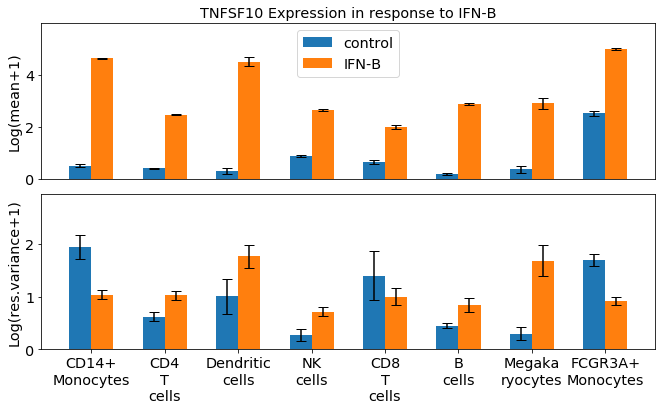

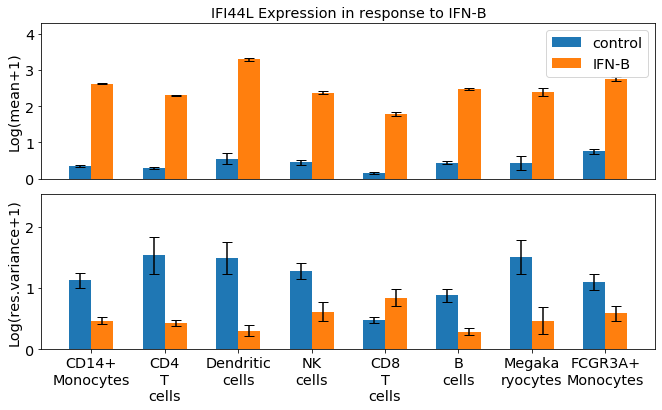

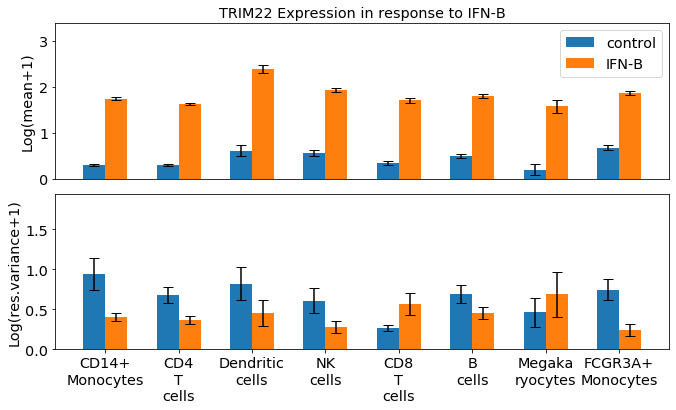

In [36]:
for gene in across_ct_genes:
    try:
        plot_exp_changes_across_ct(gene, parameter_dict, ci_dict)
    except:
        continue
    plt.savefig(data_path + 'figures/{}_across_ct.pdf'.format(gene), bbox_inches='tight')

### Expression changes across different genes for a CT

In [1]:
def plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3):

    plt.figure(figsize=(len(genes)*1.5, 7))
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([parameter_dict[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([parameter_dict[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([ci_dict[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([parameter_dict[ct + ' - ctrl']['residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([parameter_dict[ct + ' - stim']['residual_var'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([ci_dict[ct + ' - stim']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = genes
    
    plt.subplot(2, 1, 1)
    plt.title('Expression changes in {}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1.4)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Log(res.variance+1)')

In [2]:
#genes_1 = ['PTCD3', 'CDK12', 'RAB3GAP1', 'FAS', 'SETX']
genes_1 = ['HSPA5', 'KDM5A', 'FUNDC1', 'SELL', 'TRAT1']
# both sig, only var sig, both sig, both sig, both sig, only var

In [3]:
genes_2 = ['IFIT1', 'IFIT2', 'IFIT3', 'IFITM3', 'IFIT5', 'IFI27']

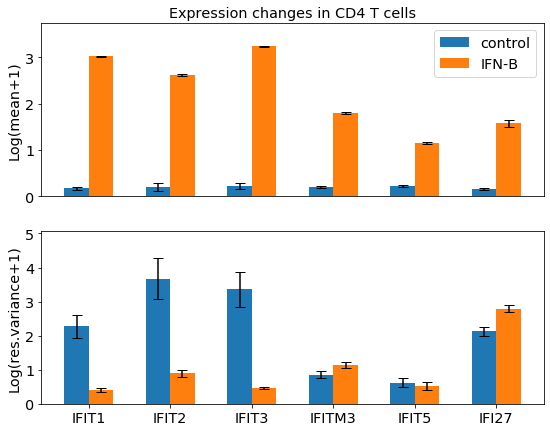

In [44]:
plot_exp_across_genes(genes_2, 'CD4 T cells', parameter_dict, ci_dict, barwidth=0.3)
plt.savefig(data_path + 'figures/cd4_across_genes.pdf'.format(gene), bbox_inches='tight')

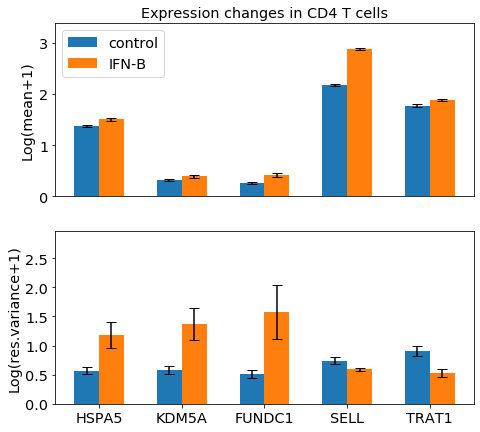

In [41]:
plot_exp_across_genes(genes_1, 'CD4 T cells', parameter_dict, ci_dict, barwidth=0.3)
plt.savefig(data_path + 'figures/cd4_across_genes_2.pdf'.format(gene), bbox_inches='tight')

### Differential expression + variability plot

In [28]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    stim_delta_dict = pkl.load(f)

In [50]:
ct = 'CD4 T cells'
de_diff = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff']
dv_diff = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff']
de_fdr = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr']
dv_fdr = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr']

In [91]:
def pretty_print(arr):
    
    for a in arr:
        print(a + ',')

In [84]:
lower_right = adata.var.index[(de_diff > 0) & (dv_diff < 0) & sig]
upper_right = adata.var.index[(de_diff > 0) & (dv_diff > 0) & sig]
lower_left = adata.var.index[(de_diff < 0) & (dv_diff < 0) & sig]
upper_left = adata.var.index[(de_diff < 0) & (dv_diff > 0) & sig]

In [88]:
lower_right

Index(['IFI6', 'IFI44L', 'IFI44', 'C1orf52', 'SELL', 'CMPK2', 'RSAD2',
       'EIF2AK2', 'ARHGAP25', 'TNFAIP6', 'GPR155', 'C2orf47', 'NCL', 'TRAT1',
       'LAMP3', 'ARAP2', 'TBC1D1', 'CYCS', 'GIMAP4', 'SLC38A5', 'LY6E',
       'IFIT2', 'IFIT3', 'IFIT1', 'ASCL2', 'TRIM22', 'CCDC85B', 'PARP11',
       'SLC38A2', 'OASL', 'EPSTI1', 'PPP2R5C', 'ZBP1', 'LGALS2'],
      dtype='object', name='index')

In [94]:
pretty_print(upper_left)

CD52,
S100A8,
CXCR4,
METTL21A,
VCAN,
COA1,
CLEC5A,
RAB33A,
NUDT5,
C10orf54,
B3GAT3,
CCS,
PTPRCAP,
RGCC,
THBS1,
PLEKHF1,
EMP3,
FAM118A,
IFNAR2,


In [71]:
pretty_print(adata.var.index[(de_diff < 0) & (dv_diff < 0) & sig])

FAM159A
PRPF38B
DUSP12
MRPL55
SMC4
PPP1R2
CDKN2AIP
C9orf142
MIS18BP1
CGRRF1
MAP2K1
UQCRC2
DLGAP1-AS1
CHMP1B
BABAM1


In [53]:
sig = (de_fdr < 0.1) & (dv_fdr < 0.2)

In [1]:
plt.scatter(de_diff[sig], dv_diff[sig], s=40, color='g')
plt.scatter(de_diff[~sig], dv_diff[~sig], s=1, color='grey')
plt.plot([0, 0], [-4, 2.5], '--', lw=5, color='k')
plt.plot([-3, 5], [0, 0], '--', lw=5, color='k')

plt.xlabel('Mean Log-FC');
plt.ylabel('Residual variance Log-FC')
plt.savefig(data_path + 'figures/cd4_2d_changes.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

### Pseudotime interferon stimulation analysis

In [606]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    ht_dict = pkl.load(f)

In [45]:
cd4_pt_df = pd.read_csv(data_path + 'cd4_timepoints.csv', index_col=0)
cd4_adata = adata[adata.obs.cell == 'CD4 T cells'].copy()
cd4_adata.obs['stim_tp'] = cd4_pt_df['stim_tp'].astype(str)
cd4_stim_adata = cd4_adata[cd4_adata.obs.stim == 'stim'].copy()
cd4_stim_adata.obs['stim_tp'] = cd4_stim_adata.obs['stim_tp'].replace('5', '4')

In [46]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=cd4_stim_adata, 
    group_label='stim_tp',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: 2
Computing observed moments for: 0
Computing observed moments for: 1
Computing observed moments for: 3
Computing observed moments for: 4


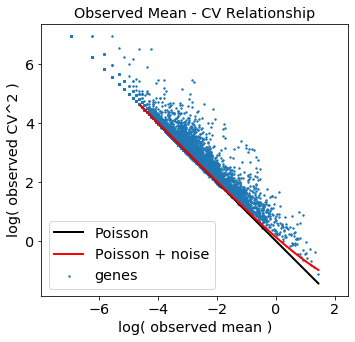

In [47]:
estimator.plot_cv_mean_curve()

In [48]:
estimator.estimate_parameters()

In [49]:
estimator.compute_confidence_intervals_1d(
    groups=estimator.groups,
    groups_to_compare=[])

Gamma RVs generated..


In [627]:
def plot_param_trajectory(gene, estimator, x_axis_width, y_axis_width):
    
    groups = [str(i) for i in range(5 if gene != 'ARL4A' else 4)] 
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    means = np.array([estimator.parameters[group]['log_mean'][gene_idx] for group in groups])
    dispersions = np.array([estimator.parameters[group]['log_residual_var'][gene_idx] for group in groups])
    
    means_ci = [estimator.parameters_confidence_intervals[group]['log_mean'][gene_idx] for group in groups]
    dispersions_ci = [estimator.parameters_confidence_intervals[group]['log_residual_var'][gene_idx] for group in groups]
    
    plt.errorbar(
        x=means, 
        y=dispersions,
        xerr=means_ci,
        yerr=dispersions_ci,
        fmt='.-',
        capsize=2,
        ecolor='k')
    plt.title(gene)

    offset=0.03
    for i, label in enumerate(groups):
        mean_offset = -0.03 if i % 2 == 0 else 0
        plt.annotate(label, (means[i] + mean_offset, dispersions[i]+dispersions_ci[i]+offset))
    
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    
    ymid = (ymin + ymax)/2
    xmid = (xmin + xmax)/2
    
    #axes.set_xlim([xmid - x_axis_width, xmid + x_axis_width])
    axes.set_ylim([ymin, ymax + 0.2])
    
    axes.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    
    

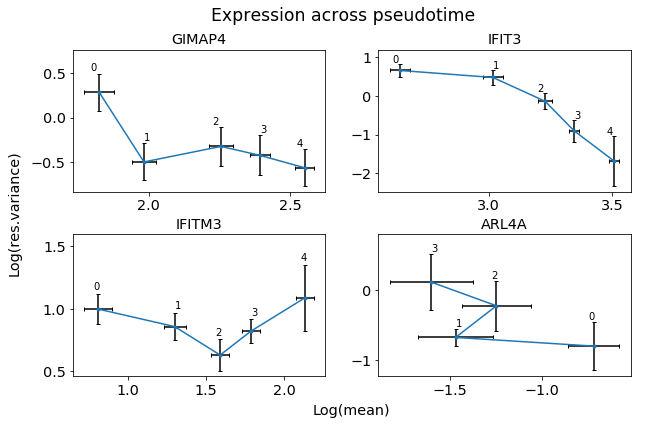

In [628]:
x_width = 0.8
y_width = 2
fig = plt.figure(figsize=(10, 6))
plt.suptitle('Expression across pseudotime')
plt.subplots_adjust(hspace=0.3, wspace=0.21)
plt.subplot(2, 2, 1)
plot_param_trajectory(
    gene='GIMAP4', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 2)
plot_param_trajectory(
    gene='IFIT3', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 3)
plot_param_trajectory(
    gene='IFITM3', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 4)
plot_param_trajectory(
    gene='ARL4A', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)

ax = fig.add_subplot(111, frameon=False);
plt.tick_params(
    which='both',
    length=0,
    labelcolor='none', 
    top='off', 
    bottom='off', 
    left='off', 
    right='off');
ax.set_xlabel('Log(mean)', labelpad=10);
ax.set_ylabel('Log(res.variance)', labelpad=25);

### TF - gene differential correlation

In [16]:
with open(data_path + 'stim_effect_1d_moments.pkl', 'rb') as f:
    moment_dict_1d = pkl.load(f)

In [17]:
with open(data_path + 'stim_effect_2d.pkl', 'rb') as f:
    dc_result = pkl.load(f)
with open(data_path + 'stim_effect_ci_2d.pkl', 'rb') as f:
    corr_ci = pkl.load(f)

In [70]:
idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']

In [71]:
genes = pd.DataFrame(
    data=list(zip(
        adata.var.index[idxs_1[gene_pair_idx[0]]], 
        adata.var.index[idxs_2[gene_pair_idx[1]]],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][gene_pair_idx],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][gene_pair_idx])),
    columns=['gene_1', 'gene_2', 'corr_1', 'corr_2'])

NameError: name 'gene_pair_idx' is not defined

In [ ]:
genes.sort_values('corr_2', ascending=False)

In [53]:
def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), 10, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    plt.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    plt.plot(x_range, line, color=sns.color_palette()[color_order])

In [54]:
def plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, gene_1, gene_2, offset=0.1):

    idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
    idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
    
    gene_idx_1 = np.where(adata.var.index == gene_1)[0][0]
    gene_idx_2 = np.where(adata.var.index == gene_2)[0][0]
    
    df_1 = pd.DataFrame(
        adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
        columns=['gene_1', 'gene_2'])
    df_2 = pd.DataFrame(
            adata[adata.obs.cell_type == ct + ' - stim'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
            columns=['gene_1', 'gene_2'])

    count_df_1 = df_1\
        .merge(
            pd.DataFrame(df_1.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')

    count_df_2 = df_2\
        .merge(
            pd.DataFrame(df_2.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')
    
    count_df_1['size'] = count_df_1[0]
    count_df_1['log_size'] = np.sqrt((count_df_1['size']))+10

    count_df_2['size'] = count_df_2[0]
    count_df_2['log_size'] = np.sqrt((count_df_2['size']))+10
    
    y1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_2].toarray().reshape(-1) - offset
    x1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_1].toarray().reshape(-1) - offset

    y2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_2].toarray().reshape(-1) + offset
    x2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_1].toarray().reshape(-1) + offset
    
    mu_x1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_1]
    mu_y1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_2]
    mu_x2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_1]
    mu_y2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_2]

    sigma_x1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_1])
    sigma_y1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_2])
    sigma_x2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_1])
    sigma_y2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_2])

    corr_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_1 = corr_ci[ct + ' - ctrl']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_2 = corr_ci[ct + ' - stim']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    plt.scatter(x1, y1, s=count_df_1.log_size, label='control')
    
    plt.scatter(x2, y2, s=count_df_2.log_size, label='IFN-B')
    
    line_from_correlation(
        corr_1, corr_ci_1, 
        x1 + offset, y1 + offset,
        mu_x1, mu_y1, sigma_x1, sigma_y1,
        color_order=0)
    
    line_from_correlation(
        corr_2, corr_ci_2, 
        x2 - offset, y2 - offset, 
        mu_x2, mu_y2, sigma_x2, sigma_y2,
        color_order=1)
    
    plt.xlabel('{} expression'.format(gene_1))
    plt.ylabel('{} expression'.format(gene_2))
    plt.legend()
    plt.title('Relationship between {} \n and {} in {}'.format(gene_1, gene_2, ct))

In [55]:
ct = 'CD4 T cells'

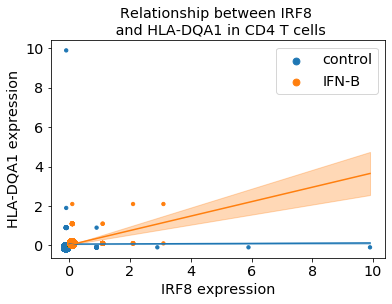

In [56]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, 'IRF8', 'HLA-DQA1', offset=0.1)

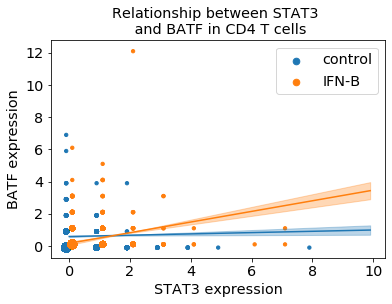

In [61]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'BATF', offset=0.1)

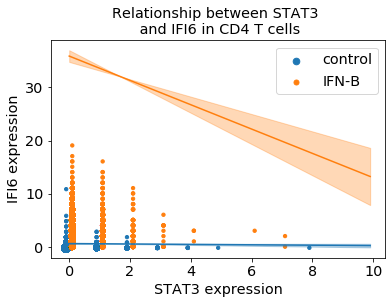

In [62]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'IFI6', offset=0.1)

### Scaling with the number of cells

In [27]:
import time

In [109]:
def one_run(N):
    
    adata_copy = adata.copy()
    sc.pp.subsample(adata_copy, n_obs=N)
    estimator = scme.SingleCellEstimator(
        adata=adata_copy,
        group_label='stim',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1)
    
    estimator.estimate_beta_sq(tolerance=3)
    estimator.estimate_parameters()
    
    start = time.time()
    imp.reload(scme)
    estimator.compute_confidence_intervals_1d(
        groups=['ctrl','stim'],
        groups_to_compare=[('ctrl', 'stim')])
    
    return time.time() - start

In [110]:
Ns = [100, 500, 1000, 2000, 3000, 5000, 10000, 20000]
more_Ns = [10000 + 1000 * i for i in range(1, 9)]

In [113]:
more_perm_times = [one_run(N) for N in more_Ns]

Computing observed moments for: ctrl
Computing observed moments for: stim


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-113-86d38b744b7e>", line 1, in <module>
    more_perm_times = [one_run(N) for N in more_Ns]
  File "<ipython-input-113-86d38b744b7e>", line 1, in <listcomp>
    more_perm_times = [one_run(N) for N in more_Ns]
  File "<ipython-input-109-67d4eb06024e>", line 19, in one_run
    groups_to_compare=[('ctrl', 'stim')])
  File "/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc/scme.py", line 409, in compute_confidence_intervals_1d
    data = self.anndata.X[cell_selector, :].toarray()
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/compressed.py", line 1024, in toarray
    out = self._process_toarray_args(order, out)
  File "/wynton/group/ye/mincheol/anaconda3/envs/sin

KeyboardInterrupt: 

In [88]:
perm_times = [one_run(N) for N in Ns]

Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..


In [42]:
times = [one_run(N) for N in Ns]

Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..
Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..


In [53]:
# Ns = [0] + Ns
# times = [0] + times

In [58]:
200/60

3.3333333333333335

In [83]:
times

[0,
 20.869556665420532,
 35.29805541038513,
 38.040297746658325,
 46.348387002944946,
 58.43357753753662,
 87.58861637115479,
 142.3105809688568,
 222.7312273979187]

In [78]:
adata_copy = adata.copy()
sc.pp.subsample(adata_copy, n_obs=20000)

In [81]:
sc.tl.rank_genes_groups(adata_copy, groupby='stim',method='wilcoxon')

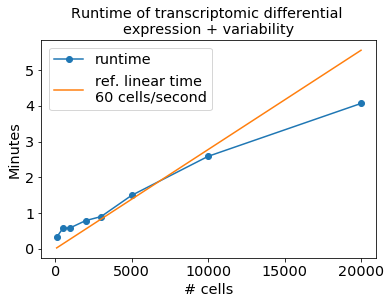

In [112]:
plt.plot(Ns, np.array(perm_times)/60, '-o', label='runtime')
plt.plot(Ns, np.array(Ns)/60/60, label='ref. linear time\n60 cells/second')
plt.legend()
plt.title('Runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/sublinear_runtime.pdf', bbox_inches='tight')

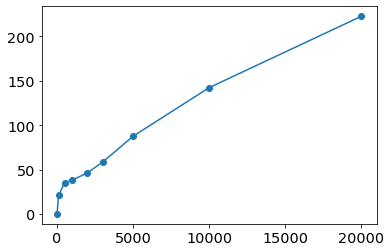

In [82]:
plt.plot(Ns, times, '-o')

#plt.plot(Ns, np.array(Ns)*times[0]/Ns[0])

In [20]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata,
    group_label='stim',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [21]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: ctrl
Computing observed moments for: stim


In [25]:
estimator.estimate_parameters()

In [153]:
ct = 'CD4 T cells'

In [ ]:
adatas

In [26]:
%%time
imp.reload(scme)
estimator.compute_confidence_intervals_1d(
    groups=['ctrl','stim'],
    groups_to_compare=[('ctrl', 'stim')])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1315, in time
    out = eval(code_2, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc/scme.py", line 409, in compute_confidence_intervals_1d
    data = self.anndata.X[cell_selector, :].toarray()
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/compressed.py", line 1035, in toarray
    csr_todense(M, N, x.indptr, x.indices, x.data, y)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/wynton/group/ye/mincheol/anaconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has n

KeyboardInterrupt: 